# Political Ideologies Prediction in News Articles

Instructions:<br>
1) Please update the path in the import data section to where you have stored the json file<br>
2) Also update the path in the implementation section to where you have stored the 2 trained models<br>
3) If you just want to see the implementation only, please do not run the Stratified Train-Test Split, Multinomial Naive Bayes and Random Forest Classifier Section as that will start retraining the model and it will take time.<br>
4) If you are running this notebook in Google Colab Free version and you want to retrain the model, run only one model at a time.<br>
5) Please Run TF-IDF section and BERT section seperately on different runtimes


## TF-IDF Method

This notebook contains code for implementation of prediction model to classify a news article as "left", "right" and "center" biased. Following are the contents of this notebook:<br>
<br>
1) Setup: Install all packages and dependencies including Spark-NLP and compatible version of pyspark, pynytimes (for NYT API) etc.<br>
2) Import Data : Import the JSON file<br>
3) Initilize All Annotators in Spark-NLP<br>
4) Setup a Preprocessing Pipeline<br>
5) Stratified Train-Test Split<br>
6) Multinomail Naive Bayes (Training Model): Contains Performance Evaluation<br>
7) Random Forest Classifier Model (Training Model): Contains Performance Evaluation<br>
8) Implementation NYT: Demonstration of application using NYT API, Feature importance for both the models and testing with specific examples


### Setup

In [1]:
#Install PySpark and SparkNLP specific versions (stable versions)
!pip install spark-nlp==5.1.4 pyspark==3.3.1
# Install nltk
! pip install nltk
# Install the package to interact with NYT API
!pip install pynytimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.7/540.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 20.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845494 sha256=2bd28a92dfc940eff18fc53e83c08304160892462d5c43dc57ede41b65510e66
  Stored in directory: /root/.cache/pip/wheels/0f/f0/3d/517368b8ce80486e84f89f214e0a022554e4ee64969f46279b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [4]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# create Spark Session and Spark Context
from pyspark.sql import SparkSession
#Import sparknlp library
import sparknlp

#Start a sparknlp session
spark = sparknlp.start()
# Check the spark session information
spark

In [7]:
#Import all the required libraries and packages
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
import nltk
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
from sparknlp.base import Finisher
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pynytimes
from pynytimes import NYTAPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data

In [8]:
# Fetch the data from the source
data_path = '/content/drive/MyDrive/Big Data Analysis/Project/released_data.json'

# spark is an existing SparkSession
data_df = spark.read.json(data_path)

# Displays the content of the DataFrame to stdout
data_df.show()

+-------------+------------------+---------------+--------------------+--------+--------------------+----------------+--------------------+
|adfontes_fair|adfontes_political|  allsides_bias|             content|event_id|                misc|          source|               title|
+-------------+------------------+---------------+--------------------+--------+--------------------+----------------+--------------------+
|         bias|              bias| From the Right|Obama administrat...|       0|{[Brooke Singman,...|        Fox News|Trump blasts Howa...|
|         bias|           neutral|From the Center|WASHINGTON – Pres...|       0|{[David Jackson],...|       USA TODAY|Trump blasts form...|
|         bias|           neutral| From the Right|Acting White Hous...|       0|{[], null, null, ...|Washington Times|Mick Mulvaney: Tr...|
|         bias|           neutral| From the Right|President Trump r...|       0|{[Dave Boyer], nu...|Washington Times|Trump says 'we'll...|
|         bias|     

In [9]:
# Take a subset of the dataframe
news_content = data_df.select(["content", "allsides_bias"])
# See the label distribution in the dataset
news_content.groupBy("allsides_bias").count().show()

### Initilize All the Annotators in Spark NLP

In [11]:
# Initilize a document assembler annotator
documentAssembler = DocumentAssembler().setInputCol('content').setOutputCol('document')

In [12]:
# Tokenize the document
tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

In [13]:
# Normalize the tokens
normalizer = Normalizer() \
                .setInputCols(["tokenized"]) \
                .setOutputCol("normalized") \
                .setLowercase(True) \
                .setMinLength(2)

In [14]:
# Download the stopwords corpus from nltk
nltk.download('stopwords')

# Store the stopwards corpus in a variable
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Initilize a stopwards clenser annotator
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['normalized']) \
     .setOutputCol('unigrams') \
     .setStopWords(eng_stopwords)

In [16]:
# Initilize a finisher annotator
finisher = Finisher() \
     .setInputCols(['unigrams'])

In [17]:
# Initilize a TF/Count Vectorizer
tfizer = CountVectorizer(inputCol='finished_unigrams', outputCol='tf_features')

In [18]:
# Initilize an IDF annotator
idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')

In [19]:
# Initilize a string indexer which converts categorical data into quantitative classes
# Majority class takes the first index and so on
# Class 0.0: From the Left
# Class 1.0: From the Right
# Class 2.0: From the Center
indexer = StringIndexer(inputCol="allsides_bias", outputCol="allsides_bias_Index")

### Setup a Preprocessing Pipeline

In [20]:
#Initilize a pipeline
preprocessing_pipline = Pipeline() \
                      .setStages([documentAssembler,
                        tokenizer,
                        normalizer,
                        stopwords_cleaner,
                        finisher,
                        tfizer,
                        idfizer,
                        indexer])

In [21]:
# Train a pipeline model
preprocessed_model = preprocessing_pipline.fit(news_content)

# Get an output dataframe
preprocessed_df = preprocessed_model.transform(news_content)

### Stratified Train-Test Split

In [ ]:
# Stratified Train-Test Split
# Get a grouped distribution of target variables and store the count
target_distribution = preprocessed_df.groupBy("allsides_bias").count().collect()

# Create a dictionary for the target distribution
target_distribution_dict = {row["allsides_bias"]: row["count"] for row in target_distribution}

# Create a fractions dictionary
fractions = {key: 0.8 for key in target_distribution_dict.keys()}

# Print both the dictionaries
print(target_distribution_dict)
print(fractions)

{'From the Left': 3684, 'From the Center': 1240, 'From the Right': 2851}
{'From the Left': 0.8, 'From the Center': 0.8, 'From the Right': 0.8}


In [ ]:
# Create a stratified train and test datasets
train_data = preprocessed_df.stat.sampleBy("allsides_bias",fractions, 0)
test_data = preprocessed_df.subtract(train_data)

In [ ]:
# Check the distribution of target labels in training dataset
train_data.groupBy("allsides_bias").count().show()

+---------------+-----+
|  allsides_bias|count|
+---------------+-----+
|  From the Left| 2962|
|From the Center|  998|
| From the Right| 2222|
+---------------+-----+



In [ ]:
# Check the distribution of target labels in test dataset
test_data.groupBy("allsides_bias").count().show()

+---------------+-----+
|  allsides_bias|count|
+---------------+-----+
|  From the Left|  718|
|From the Center|  241|
| From the Right|  625|
+---------------+-----+



### Multinomial Naive Bayes Model

In [ ]:
# Initilize a MNB Model
# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol="tf_idf_features", labelCol="allsides_bias_Index", predictionCol="predictions_nb")

In [ ]:
# Train the model on training dataset
model_mnb = nb.fit(train_data)

# Get predictions for the test dataset
predictions_nb = model_mnb.transform(test_data)

#### Performance Evaluation

In [ ]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="allsides_bias_Index", predictionCol="predictions_nb",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions_nb)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.6047979797979798


In [ ]:
# Compute raw scores on the test set
predictionAndLabels_nb = predictions_nb.rdd.map(lambda lp: (lp.predictions_nb, lp.allsides_bias_Index))

In [ ]:
# check
predictionAndLabels_nb.first()

(0.0, 0.0)

In [ ]:
# Instantiate metrics object
metrics_nb = MulticlassMetrics(predictionAndLabels_nb)

# Statistics by class
labels = predictions_nb.rdd.map(lambda lp: lp.allsides_bias_Index).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics_nb.precision(label)))
    print("Class %s recall = %s" % (label, metrics_nb.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics_nb.fMeasure(label)))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0 precision = 0.7027027027027027
Class 0.0 recall = 0.6155988857938719
Class 0.0 F1 Measure = 0.6562731997030439
Class 1.0 precision = 0.666095890410959
Class 1.0 recall = 0.6224
Class 1.0 F1 Measure = 0.6435070306038048
Class 2.0 precision = 0.3423180592991914
Class 2.0 recall = 0.5269709543568465
Class 2.0 F1 Measure = 0.41503267973856217


In [ ]:
# Calculate the weighted F1 Measure
metrics_nb.weightedFMeasure()

0.614532151092902

In [ ]:
# Save the model
model_mnb.write().overwrite().save("/content/drive/MyDrive/Big Data Analysis/Project/Trained_Model/tfidf_multi_nb_model")

### Random forest Classifier Model

In [ ]:
# Initilize a Random Forest Classification model
r_forest  = RandomForestClassifier(featuresCol='tf_idf_features', labelCol='allsides_bias_Index', predictionCol='prediction_rf', numTrees=100, maxDepth=30)

In [ ]:
# Train the model on the training dataset
rf_model = r_forest.fit(train_data)

# Get predictions for the test dataset
prediction_rf = rf_model.transform(test_data)

In [ ]:
# Check the important parameters used
rf_model.getParam

<bound method Params.getParam of RandomForestClassificationModel: uid=RandomForestClassifier_ae5cc588d857, numTrees=100, numClasses=3, numFeatures=74223>

#### Performance Evaluation

In [ ]:
# compute accuracy on the test set
evaluator_rf = MulticlassClassificationEvaluator(labelCol="allsides_bias_Index", predictionCol="prediction_rf",
                                              metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(prediction_rf)
print("Test set accuracy = " + str(accuracy_rf))

Test set accuracy = 0.6824494949494949


In [ ]:
# Compute raw scores on the test set
predictionAndLabels_rf = prediction_rf.rdd.map(lambda lp: (lp.prediction_rf, lp.allsides_bias_Index))

In [ ]:
# Check
predictionAndLabels_rf.first()

(0.0, 0.0)

In [ ]:
# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)

# Statistics by class
labels_rf = prediction_rf.rdd.map(lambda lp: lp.allsides_bias_Index).distinct().collect()
for label in sorted(labels_rf):
    print("Class %s precision = %s" % (label, metrics_rf.precision(label)))
    print("Class %s recall = %s" % (label, metrics_rf.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics_rf.fMeasure(label)))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0 precision = 0.603202846975089
Class 0.0 recall = 0.9442896935933147
Class 0.0 F1 Measure = 0.7361563517915309
Class 1.0 precision = 0.8666666666666667
Class 1.0 recall = 0.5824
Class 1.0 F1 Measure = 0.6966507177033493
Class 2.0 precision = 0.975
Class 2.0 recall = 0.16182572614107885
Class 2.0 F1 Measure = 0.2775800711743772


In [ ]:
# Calculate the Weighted F1 Measure
metrics_rf.weightedFMeasure()

0.6507978259494556

In [ ]:
# Save the model
rf_model.write().overwrite().save("/content/drive/MyDrive/Big Data Analysis/Project/Trained_Model/tfidf_random_forest_model")

### Implementation: NYT

In [22]:
# Load the saved Random Forest Classification Model
tf_rf_model = RandomForestClassificationModel.load("/content/drive/MyDrive/Big Data Analysis/Project/Trained_Model/tfidf_random_forest_model")

# Load the saved Multinimoal Naive Bayes Model
tf_mnb_model = NaiveBayesModel.load("/content/drive/MyDrive/Big Data Analysis/Project/Trained_Model/tfidf_multi_nb_model")

In [23]:
# View the preprocessed training data
preprocessed_df.show()

+--------------------+---------------+--------------------+--------------------+--------------------+-------------------+
|             content|  allsides_bias|   finished_unigrams|         tf_features|     tf_idf_features|allsides_bias_Index|
+--------------------+---------------+--------------------+--------------------+--------------------+-------------------+
|Obama administrat...| From the Right|[obama, administr...|(74223,[0,1,2,4,5...|(74223,[0,1,2,4,5...|                1.0|
|WASHINGTON – Pres...|From the Center|[washington, pres...|(74223,[0,1,2,3,4...|(74223,[0,1,2,3,4...|                2.0|
|Acting White Hous...| From the Right|[acting, white, h...|(74223,[0,1,2,3,4...|(74223,[0,1,2,3,4...|                1.0|
|President Trump r...| From the Right|[president, trump...|(74223,[1,2,3,5,1...|(74223,[1,2,3,5,1...|                1.0|
|President Donald ...|From the Center|[president, donal...|(74223,[0,1,2,3,4...|(74223,[0,1,2,3,4...|                2.0|
|President Donald ...|  

#### Feature Importance - Random Forest Classifier Model

In [24]:
# Get the output from Count Vectorization/TF stage of the pipeline
count_v = preprocessed_model.stages[5]

In [25]:
# Extract the vovalulary used by the count vectorizer
vocab = count_v.vocabulary

In [26]:
# check the vocab
vocab

['said',
 'trump',
 'president',
 'mr',
 'would',
 'house',
 'us',
 'obama',
 'also',
 'new',
 'people',
 'one',
 'state',
 'republican',
 'white',
 'could',
 'campaign',
 'republicans',
 'states',
 'senate',
 'told',
 'clinton',
 'time',
 'democrats',
 'government',
 'two',
 'last',
 'first',
 'news',
 'trumps',
 'bill',
 'like',
 'even',
 'years',
 'many',
 'former',
 'national',
 'washington',
 'year',
 'american',
 'administration',
 'percent',
 'law',
 'united',
 'congress',
 'security',
 'political',
 'officials',
 'democratic',
 'going',
 'get',
 'federal',
 'made',
 'make',
 'vote',
 'say',
 'may',
 'back',
 'week',
 'country',
 'party',
 'election',
 'court',
 'including',
 'support',
 'tuesday',
 'statement',
 'department',
 'think',
 'day',
 'report',
 'according',
 'tax',
 'health',
 'police',
 'take',
 'still',
 'dont',
 'public',
 'deal',
 'called',
 'since',
 'way',
 'committee',
 'thursday',
 'gop',
 'saying',
 'presidential',
 'well',
 'americans',
 'monday',
 'office'

In [27]:
# Extract most important features from the Random Forest Classifier Model
feat_imp = tf_rf_model.featureImportances

In [28]:
# Extract the important features or words along with their importance values in
# a dataframe
rf_fea_imp = pd.DataFrame(zip(vocab, feat_imp.values), columns=['vocab', 'values']).sort_values(by = 'values', ascending=False)

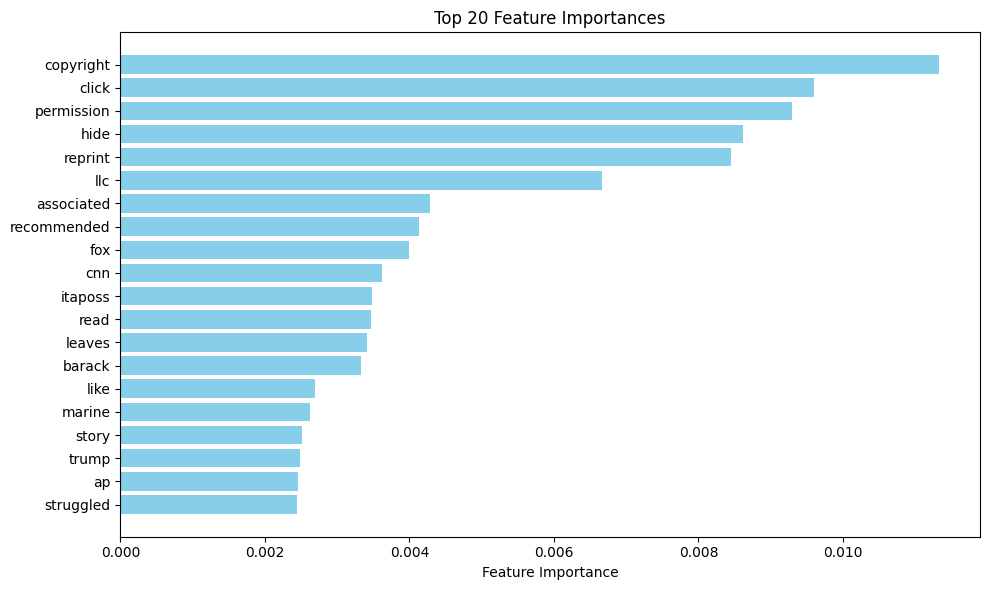

In [29]:
# Take top 20 values and corresponding vocab
top_20 = rf_fea_imp.head(20)

# Plot top 20 values corresponding to vocab
plt.figure(figsize=(10, 6))
plt.barh(top_20['vocab'], top_20['values'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest feature at the top
plt.tight_layout()
plt.show()

#### NYT API Demostration (Unsupervised)


In [33]:
# The API Key
api_key = "your_api_key"

In [34]:
# Create a new NYTAPI object with your API key.
nyt = NYTAPI(api_key, parse_dates=True)

In [35]:
# Get the top stories from NYT
top_stories = nyt.top_stories(section = "politics")

In [36]:
# View
top_stories

[{'section': 'us',
  'subsection': 'politics',
  'title': 'House Passes Defense Bill, Clearing It for Biden',
  'abstract': 'Republicans and Democrats banded together to push through the legislation over the objections of right-wing lawmakers, who had sought abortion, transgender care and diversity restrictions.',
  'url': 'https://www.nytimes.com/2023/12/14/us/politics/defense-bill-congress.html',
  'uri': 'nyt://article/e7611600-f736-5e64-9d36-f5b82deb678e',
  'byline': 'By Karoun Demirjian',
  'item_type': 'Article',
  'updated_date': datetime.datetime(2023, 12, 14, 11, 37, 45, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))),
  'created_date': datetime.datetime(2023, 12, 14, 10, 47, 9, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))),
  'published_date': datetime.datetime(2023, 12, 14, 10, 47, 9, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))),
  'material_type_facet': '',
  'kicker': '',
  'des_facet': ['Federal Budge

In [37]:
# Check the abstract of first
top_stories[0]['abstract']

'Republicans and Democrats banded together to push through the legislation over the objections of right-wing lawmakers, who had sought abortion, transgender care and diversity restrictions.'

In [38]:
# Create a dataframe from the top stories in the same format as training data
# so that it can be preprocessed using preprocessing pipeline model
inference_df = spark.createDataFrame(pd.DataFrame([(i['section'],i['abstract'],0) for i in top_stories], columns = ['section', 'content', 'all_sides_bias']))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [39]:
#check
inference_df.show()

+----------+--------------------+--------------+
|   section|             content|all_sides_bias|
+----------+--------------------+--------------+
|        us|Republicans and D...|             0|
|        us|The fallout over ...|             0|
|  business|The Treasury Depa...|             0|
|        us|Given Republicans...|             0|
|        us|J.R. Majewski, an...|             0|
|technology|The Global Engage...|             0|
|        us|With aid to Ukrai...|             0|
|        us|Ruby Freeman, one...|             0|
|        us|Negotiators are r...|             0|
|        us|Stanford, Rutgers...|             0|
|        us|A celebrated “adv...|             0|
|        us|Democratic candid...|             0|
|        us|The fund, meant t...|             0|
|        us|The decision by t...|             0|
|        us|The former presid...|             0|
|        us|A ruling by the S...|             0|
|        us|The president’s s...|             0|
|        us|Surging 

In [40]:
#check the schema
inference_df.printSchema()

root
 |-- section: string (nullable = true)
 |-- content: string (nullable = true)
 |-- all_sides_bias: long (nullable = true)



In [41]:
# Transform the dataframe through the preprocessing pipeline model
nyt_df = preprocessed_model.transform(inference_df)

In [42]:
# Predict the label for the top stories
nyt_df_pred = tf_rf_model.transform(nyt_df)

In [43]:
# Get distinct prediction labels
nyt_df_pred.select('prediction_rf').distinct().show()

+-------------+
|prediction_rf|
+-------------+
|          1.0|
+-------------+



#### Testing in a Supervised Manner

We are giving such articles of which we know the bias. The aim is to evaluate how well the model is working. We can analyze the results and based on it tune the model if required.

In [44]:
# This is an example article of class 'left' bias
text_0 =  """ The meeting in Brussels, less than two weeks into the campaign, illustrates how a counteroffensive born in optimism has failed to deliver its expected punch, generating friction and second-guessing between Washington and Kyiv and raising deeper questions about Ukraine’s ability to retake decisive amounts of territory.

As winter approaches, and the front lines freeze into place, Ukraine’s most senior military officials acknowledge that the war has reached a stalemate.

This examination of the lead-up to Ukraine’s counteroffensive is based on interviews with more than 30 senior officials from Ukraine, the United States and European nations. It provides new insights and previously unreported details about America’s deep involvement in the military planning behind the counteroffensive and the factors that contributed to its disappointments. The second part of this two-part account examines how the battle unfolded on the ground over the summer and fall, and the widening fissures between Washington and Kyiv. Some of the officials spoke on the condition of anonymity to discuss sensitive deliberations.

Key elements that shaped the counteroffensive and the initial outcome include:

● Ukrainian, U.S. and British military officers held eight major tabletop war games to build a campaign plan. But Washington miscalculated the extent to which Ukraine’s forces could be transformed into a Western-style fighting force in a short period — especially without giving Kyiv air power integral to modern militaries.

● U.S. and Ukrainian officials sharply disagreed at times over strategy, tactics and timing. The Pentagon wanted the assault to begin in mid-April to prevent Russia from continuing to strengthen its lines. The Ukrainians hesitated, insisting they weren’t ready without additional weapons and training.

● U.S. military officials were confident that a mechanized frontal attack on Russian lines was feasible with the troops and weapons that Ukraine had. The simulations concluded that Kyiv’s forces, in the best case, could reach the Sea of Azov and cut off Russian troops in the south in 60 to 90 days.

● The United States advocated a focused assault along that southern axis, but Ukraine’s leadership believed its forces had to attack at three distinct points along the 600-mile front, southward toward both Melitopol and Berdyansk on the Sea of Azov and east toward the embattled city of Bakhmut.

● The U.S. intelligence community had a more downbeat view than the U.S. military, assessing that the offensive had only a 50-50 chance of success given the stout, multilayered defenses Russia had built up over the winter and spring.

● Many in Ukraine and the West underestimated Russia’s ability to rebound from battlefield disasters and exploit its perennial strengths: manpower, mines and a willingness to sacrifice lives on a scale that few other countries can countenance.

● As the expected launch of the offensive approached, Ukrainian military officials feared they would suffer catastrophic losses — while American officials believed the toll would ultimately be higher without a decisive assault.

The year began with Western resolve at its peak, Ukrainian forces highly confident and President Volodymyr Zelensky predicting a decisive victory. But now, there is uncertainty on all fronts. Morale in Ukraine is waning. International attention has been diverted to the Middle East. Even among Ukraine’s supporters, there is growing political reluctance to contribute more to a precarious cause. At almost every point along the front, expectations and results have diverged as Ukraine has shifted to a slow-moving dismounted slog that has retaken only slivers of territory.

“We wanted faster results,” Zelensky said in an interview with the Associated Press last week. “From that perspective, unfortunately, we did not achieve the desired results. And this is a fact.”

Together, all these factors make victory for Ukraine far less likely than years of war and destruction.

The campaign’s inconclusive and discouraging early months pose sobering questions for Kyiv’s Western backers about the future, as Zelensky — supported by an overwhelming majority of Ukrainians — vows to fight until Ukraine restores the borders established in its 1991 independence from the Soviet Union.

“That’s going to take years and a lot of blood,” a British security official said, if it’s even possible. “Is Ukraine up for that? What are the manpower implications? The economic implications? Implications for Western support?”

The year now stands to end with Russian President Vladimir Putin more certain than ever that he can wait out a fickle West and fully absorb the Ukrainian territory already seized by his troops."""

In [45]:
# Create a dataframe
text_0_df = spark.createDataFrame(pd.DataFrame([('random',text_0,0)], columns = ['section', 'content', 'all_sides_bias']))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [46]:
# Preprocess the test data
text_0_df = preprocessed_model.transform(text_0_df)

# Make prediction on the test data
text_0_pred_df = tf_rf_model.transform(text_0_df)

In [47]:
# Get the prediction output
text_0_pred_df.select('prediction_rf').distinct().show()

+-------------+
|prediction_rf|
+-------------+
|          0.0|
+-------------+



The above results show that the model is able to classify the "left" biased articles properly.

In [48]:
# This is an example article of class 'right' bias
text_1 =  """An American warship and multiple commercial vessels were attacked in the Red Sea on Sunday, the Pentagon said, in what may mark a major escalation of military activity in the Middle East related to the Israel-Hamas conflict.
"We’re aware of reports regarding attacks on the USS Carney and commercial vessels in the Red Sea and will provide information as it becomes available," the Pentagon said, according to The Associated Press.
The British military said earlier in the day that a suspected drone attack and explosions occurred in the Red Sea, but it did not provide further details.
The Pentagon did not identify a source of the attacks in the Red Sea, but Yemen's Houthi rebels have launched several recent attacks on ships in the region.
The USS Carney has shot down multiple missiles and drones launched from Yemen since Oct. 7, when terrorists from the Gaza Strip invaded Israel and killed about 1,200 people and took 240 others captive.
The Iran-backed group, which the Biden administration delisted as terrorists, has also ramped up attacks on Israel since Oct. 7."""

In [49]:
# Create a dataframe
text_1_df = spark.createDataFrame(pd.DataFrame([('random',text_1,0)], columns = ['section', 'content', 'all_sides_bias']))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [50]:
# Preprocess the test data
text_1_df = preprocessed_model.transform(text_1_df)

# Make prediction on the test data
text_1_pred_df = tf_rf_model.transform(text_1_df)

In [51]:
# Get the prediction output
text_1_pred_df.select('prediction_rf').distinct().show()

+-------------+
|prediction_rf|
+-------------+
|          1.0|
+-------------+



The above results show that the model is able to classify the "right" biased articles properly.

In [52]:
# This is an example article of class 'center' bias
text_2 =  """Senate Republicans who are concerned about former President Trump’s viability in a general election now see Nikki Haley as the last, best chance of denying Trump the GOP presidential nomination and averting what they see as a potential general election disaster.
GOP senators who don’t support Trump acknowledge he could win the presidency, given President Biden’s weak job approval ratings, but they view Haley as much more electable because she does not alienate independent and suburban women voters like Trump does.

They are worried that if Trump is the GOP nominee, it could still lead to a disastrous result for their party.
GOP lawmakers recognize that Trump has a commanding lead in GOP primary polls, but many see Haley as a better choice because she does not face Trump’s legal issues that include 91 felony counts in four separate criminal trials.
They also see Haley as a candidate far less likely to blindside them with wild statements or sudden sweeping policy pronouncements that would become political landmines in next year’s battle for the Senate majority.
The growing buzz around Haley comes at a time when many GOP senators are writing off Florida Gov. Ron DeSantis’s chances of staging a comeback.
“She has better prospects than he does because her numbers are going up and his are coming down. Usually, you want to place your bet on someone who is doing better,” said Sen. Mitt Romney (R-Utah), who has urged Republican donors to coalesce around an alternative to Trump as early as possible in next year’s primary.
Senate Republican Whip John Thune (S.D.), who has repeatedly stressed the importance of appealing to moderate and independent voters beyond the GOP’s conservative base, said Haley “seems to be” emerging as the leading alternative to Trump.

“She’s acquitted herself really well in the debates, and I think has done well out on the stump. Part of running for national office — especially in those early states — is relatability, and I think she’s got a good retail political style. Seems to be winning over some people,” he said.
Thune, who initially endorsed Sen. Tim Scott’s (R-S.C.) bid for the nomination, said Trump “starts with a very commanding lead” in national and battleground polls. But he and other senators think the race is still fluid.
“I guess the question is how much she can shift that narrative,” he said.

Senate Republicans are expecting Haley to get more media attention and another possible bump in the polls after the fourth Republican presidential debate, scheduled for Wednesday, Dec. 6, in Tuscaloosa, Ala. That debate is hosted by NewsNation, the sister network to The Hill.
Haley scored points in the earlier debates by going toe-to-toe with businessman Vivek Ramaswamy, who has since lost momentum in the race.
Sen. Mike Rounds (R-S.C.), who also endorsed Scott, said Haley is surging at the right moment a few weeks before the Iowa caucuses, scheduled for Jan. 15.

He thinks Republican voters are starting to think more seriously about shifting away from Trump, though they’re not there yet.
“The Republicans aren’t ready to make changes yet in their decision making — they’re getting closer. So I think her timing is probably pretty key,” Rounds said. “It will depend now on what the other candidates say and whether the other candidates decide they want to continue to battle on.
“After the Iowa caucuses, after New Hampshire, I think this will be narrowed down to a two-person race,” he added. “I think she has momentum.”

Scott dropped out of the race Nov. 13 and former Vice President Mike Pence dropped out Oct. 28. The other remaining candidates, including Ramaswamy, former New Jersey Gov. Chris Christie and North Dakota Gov. Doug Burgum, are polling in the mid to low single digits in national polls.
Haley’s biggest problem for the much of the past year is that she was stuck behind DeSantis as the leading alternative to Trump. But now that has changed, GOP senators say, and the new pecking order was underscored last week when Americans For Prosperity, the political arm of the powerful Koch network, endorsed Haley.
“I do believe that she’s starting to move ahead. To use the [Formula 1 racing] analogy, she’s probably in the P2 position now, moved up ahead of DeSantis,” said Sen. Thom Tillis (R-N.C.), who isn’t making an endorsement in the presidential primary.

Tillis said Americans For Prosperity has “a pretty good ground game,” which could help Haley turn out voters in key primary states.
“If DeSantis doesn’t perform in Iowa, and she does, then it sets her up for New Hampshire, and it becomes an interesting contest,” he added.
Tillis said DeSantis “peaked early and probably was playing it a little bit too safe at a time when he could have had a breakout moment.”

“Using a Florida, NASA analogy, I think the launch window has passed,” he added. “I wouldn’t count out Nikki Haley. She came in as governor [of South Carolina] the year I came in as Speaker of the [North Carolina] House, and I have a lot of admiration for the way she led South Carolina.”
DeSantis has put a heavy emphasis on winning Iowa, but even if he does, GOP lawmakers note that victory in the Hawkeye State hasn’t translated into success in other state in recent presidential primaries.
Former Sen. Judd Gregg (R-N.H.), who endorsed Haley in October, described her as the only candidate to capture the imagination and interest of people who doubt or don’t want Trump as a nominee.
“If we want to win the presidency, she’s the person to do it,” he said. “All swing states are determined by the independent voters. Most independents today, at least in New Hampshire, are educated women. They won’t vote for Trump under any circumstance.”
Gregg said he doesn’t see DeSantis making a comeback in New Hampshire, even if he wins Iowa.

shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown shutdown border border border border border border border border border border border border border border border border border.

“Iowa has never had a huge impact on downfield primaries,” he said. “Iowa picks corn and New Hampshire wins presidents. … If you look historically, the person who comes out of Iowa [as the winner] doesn’t go very far, unless they’re the perceived front-runner.”
Texas Sen. Ted Cruz (R) won the Iowa caucuses in 2016, and former Sen. Rick Santorum (R-Pa.) and former Arkansas Gov. Mike Huckabee (R) won them in 2012 and 2008, respectively.
Some senators think Trump’s sudden declaration that he would make another attempt to repeal the Affordable Care Act if elected was an attempt to burnish his conservative credentials and paint Haley as a moderate.
“I think he’s going to be more concerned about Nikki Haley getting the support that she has from the Koch group, so you’re going to see him trying to do things to activate his base of support,” Romney predicted.
Haley is now in third place behind Trump and DeSantis, according to an average of recent national polls compiled by Real Clear Politics. But DeSantis’s national poll numbers have dropped substantially since March, and Haley is only a few points behind him.
Several recent polls, including a Washington Post/Monmouth University poll conducted last month, find Haley in second place in New Hampshire, which hosts the second contest of the presidential primary. DeSantis has lagged behind in fourth place in three November polls of New Hampshire voters.
A strong showing in New Hampshire on Jan. 23 would give Haley strong momentum heading into South Carolina’s Feb. 24 primary. She has a home-field advantage in the state after serving as governor from 2011-17.
Since 1980, the winner of the South Carolina Republican presidential primary has gone on to win the party’s nomination every time except for 2012, when former Speaker Newt Gingrich (R-Ga.) won it.
Trump won the South Carolina in 2016 with 33 percent of the vote, while Cruz and Rep. Marco Rubio (R-Fla.) tied for second place with 22 percent each."""

In [53]:
# Create a dataframe
text_2_df = spark.createDataFrame(pd.DataFrame([('random',text_2,0)], columns = ['section', 'content', 'all_sides_bias']))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [54]:
# Preprocess the test data
text_2_df = preprocessed_model.transform(text_2_df)

# Make prediction on the test data
text_2_pred_df = tf_rf_model.transform(text_2_df)

In [55]:
# Get the prediction output
text_2_pred_df.select('prediction_rf').distinct().show()

+-------------+
|prediction_rf|
+-------------+
|          0.0|
+-------------+



The above results confirms that it is difficult to classify the "center" biased articles as the TF-IDF based model which is a bag of words approach. The words that appear in these articles appear in both "left" and "right" biased articles as it tries to convey opinions of both the sides, making it difficult to classify.

#### Feature Importance in Multinomial Naive Bayes

Our aim here is to perform feature importance in Multinomial Naive Bayes model by each class to analyze the most important words or features the model considered for its classification.

In [56]:
# Extract the coefficient values from the MNB model
mnb_coef = tf_mnb_model.theta.toArray()

In [57]:
# Create a dataframe with vocab and the coefficient values for "left" biased articles
mnb_left_coef = pd.DataFrame(zip(vocab, mnb_coef[0]), columns=['vocab', 'left_coef']).sort_values(by = 'left_coef', ascending=False)

# Display the first and last 5 rows
display(mnb_left_coef.head())
display(mnb_left_coef.tail())

,vocab,left_coef
3,mr,-5.771675
1,trump,-6.327954
21,clinton,-6.597212
7,obama,-6.791712
74,police,-6.943871


,vocab,left_coef
50727,candis,-15.38605
50725,shaheengop,-15.38605
50724,bastins,-15.38605
50721,pakistanbased,-15.38605
74222,newssurvey,-15.38605


In [58]:
# Display the top 40 important words/features in "left" biased articles
display(mnb_left_coef.head(40))

,vocab,left_coef
3,mr,-5.771675
1,trump,-6.327954
21,clinton,-6.597212
7,obama,-6.791712
74,police,-6.943871
17,republicans,-7.056826
16,campaign,-7.065309
19,senate,-7.089970
30,bill,-7.108993
5,house,-7.153897


In [59]:
# Show them in a list format
", ".join(list(mnb_left_coef.vocab.head(40).values))

'mr, trump, clinton, obama, police, republicans, campaign, senate, bill, house, democrats, states, sanders, trumps, state, united, republican, court, tax, romney, health, cruz, vote, party, cnn, voters, percent, immigration, gun, white, government, deal, debate, people, ms, military, would, officials, law, said'

In [60]:
# Create a dataframe with vocab and the coefficient values for "right" biased articles
mnb_right_coef = pd.DataFrame(zip(vocab, mnb_coef[1]), columns=['vocab', 'right_coef']).sort_values(by = 'right_coef', ascending=False)

# Display the first and last 5 records
display(mnb_right_coef.head())
display(mnb_right_coef.tail())

,vocab,right_coef
3,mr,-6.049508
1,trump,-6.244387
270,click,-6.584739
41,percent,-6.668764
7,obama,-6.696932


,vocab,right_coef
48391,slightfor,-14.729273
48392,ignani,-14.729273
48393,unpresidented,-14.729273
48394,psyched,-14.729273
19382,malian,-14.729273


In [61]:
# Display the top 10 important important words/features for "right" biased articles
display(mnb_right_coef.head(10))

,vocab,right_coef
3,mr,-6.049508
1,trump,-6.244387
270,click,-6.584739
41,percent,-6.668764
7,obama,-6.696932
21,clinton,-6.781358
72,tax,-6.964350
19,senate,-6.979248
179,fox,-6.998827
5,house,-7.015170


In [62]:
# Show them in a list format
", ".join(list(mnb_right_coef.vocab.head(40).values))

'mr, trump, click, percent, obama, clinton, tax, senate, fox, house, bill, democrats, republicans, police, romney, us, campaign, sanders, court, north, state, government, vote, republican, health, sen, news, cruz, white, security, president, attack, press, report, military, administration, obamacare, federal, spending, law'

In [63]:
# Create a dataframe with vocab and the coefficient values for "center" biased articles
mnb_center_coef = pd.DataFrame(zip(vocab, mnb_coef[2]), columns=['vocab', 'center_coef']).sort_values(by = 'center_coef', ascending=False)

# Display the first and last 5 records
display(mnb_center_coef.head())
display(mnb_center_coef.tail())

,vocab,center_coef
1,trump,-5.813463
338,shutdown,-6.683361
29,trumps,-6.722085
6,us,-6.807430
150,border,-6.870730


,vocab,center_coef
39972,villanueva,-14.100638
39973,maddows,-14.100638
39974,hounds,-14.100638
39976,negating,-14.100638
74222,newssurvey,-14.100638


In [64]:
# Display the top 10 important important words/features for "center" biased articles
display(mnb_center_coef.head(10))

,vocab,center_coef
1,trump,-5.813463
338,shutdown,-6.683361
29,trumps,-6.722085
6,us,-6.807430
150,border,-6.870730
3,mr,-6.871435
19,senate,-6.899014
30,bill,-6.952830
5,house,-6.979955
62,court,-6.990020


In [65]:
# Show them in a list format
", ".join(list(mnb_center_coef.vocab.head(40).values))

'trump, shutdown, trumps, us, border, mr, senate, bill, house, court, trade, kavanaugh, says, clinton, russia, tax, democrats, immigration, police, white, campaign, state, north, investigation, percent, fbi, government, security, russian, election, wall, mueller, congress, republicans, vote, federal, law, said, former, officials'

## Exploratory Data Analysis

In [ ]:
#Importing required libraries
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk # Bring in the NLP toolkit
nltk.download('punkt')
import itertools
from wordcloud import WordCloud
from google.colab import drive

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing Dataset
#filepath = "/content/drive/MyDrive/Big Data Analysis/Project/released_data.json"
filepath = "/content/drive/MyDrive/Colab Notebooks/BDA/Project/released_data.json"

with open(filepath, mode='r') as fp:
    file = fp.read()

In [ ]:
# Split the file contents into a list using newline character as the separator
dict_1 = file.split('\n')

# Remove the last element from the list, assuming it's an empty string or incomplete JSON
dict_1 = dict_1[:-1]

# Parse each string element in the list as JSON and reconstruct the list
dict_1 = [json.loads(i) for i in dict_1]

# Extract and display the keys of the first JSON object in the list
print(dict_1[0].keys())
#Creating a dataframe
df = pd.DataFrame(dict_1)

dict_keys(['source', 'title', 'event_id', 'adfontes_fair', 'adfontes_political', 'allsides_bias', 'content', 'misc'])


In [ ]:
df.info() #Checking the structure of the dataframes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7775 entries, 0 to 7774
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              7775 non-null   object
 1   title               7775 non-null   object
 2   event_id            7775 non-null   int64 
 3   adfontes_fair       7775 non-null   object
 4   adfontes_political  7775 non-null   object
 5   allsides_bias       7775 non-null   object
 6   content             7775 non-null   object
 7   misc                7775 non-null   object
dtypes: int64(1), object(7)
memory usage: 486.1+ KB


### Bias Distribution

In [ ]:
df['allsides_bias'].value_counts(normalize=True)

From the Left      0.473826
From the Right     0.366688
From the Center    0.159486
Name: allsides_bias, dtype: float64

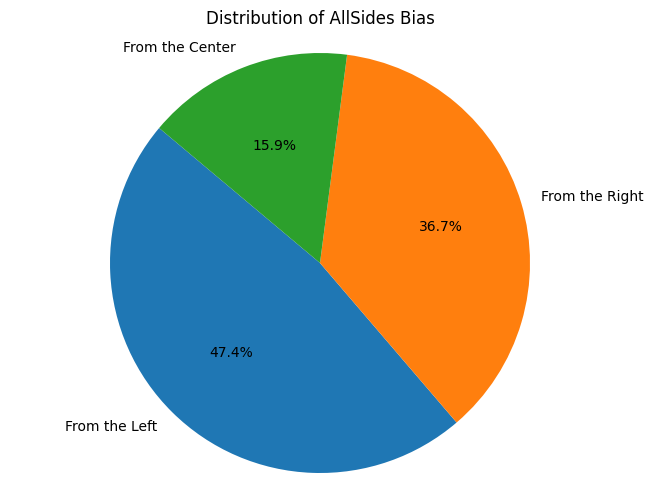

In [ ]:
bias_counts = df['allsides_bias'].value_counts()
# Create a pie chart using Seaborn
plt.figure(figsize=(8, 6))
plt.pie(bias_counts, labels=bias_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of AllSides Bias')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Top Publishers

In [ ]:
df['source'].value_counts() #Checking the count by publishers

CNN (Web News)           1021
Fox News                 1002
New York Times - News     781
Washington Times          657
HuffPost                  539
                         ... 
Rich Lowry                  1
NPR News                    1
Michael Barone              1
Ross Douthat                1
Accuracy in Media           1
Name: source, Length: 113, dtype: int64

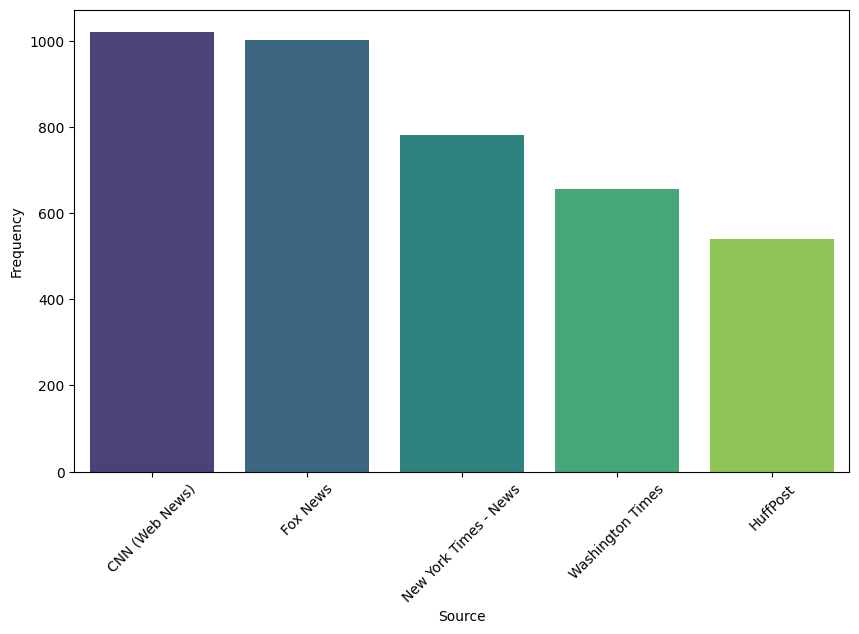

In [ ]:
# Calculating the frequency count of the 'source' column and selecting the top 5 sources
freq = df['source'].value_counts().head(5)

# Grouping by 'source', counting the occurrences, sorting in descending order, and selecting the top 5 sources
top_5_source = df.groupby('source').count().reset_index() \
                 .sort_values(['event_id'], ascending=False) \
                 .head(5)

# Extracting the top 5 source names
top_5 = top_5_source['source']

# Creating a bar plot to visualize the frequency of top 5 sources
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5.values, y=freq, palette='viridis')

# Labeling the plot axes and setting rotation for source names on x-axis
plt.xlabel('Source')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Displaying the plot
plt.show()

In [ ]:
#Tokenize the reviewText column in the dataframe
content_tokens = [nltk.word_tokenize(i) for i in df['content']]
from numpy.core.fromnumeric import mean
len_article = []
for i in content_tokens:
  len_article.append(len(i))
print(mean(len_article))

952.4216077170418


In [ ]:
df_center = df[df['allsides_bias'] == 'From the Center']
df_right = df[df['allsides_bias'] == 'From the Right']
df_left = df[df['allsides_bias'] == 'From the Left']

In [ ]:
center_words = [nltk.word_tokenize(i) for i in df_center['content']]
right_words = [nltk.word_tokenize(i) for i in df_right['content']]
left_words = [nltk.word_tokenize(i) for i in df_left['content']]


In [ ]:
# Let's try taking out the stopwords beforehand
nltk.download('stopwords')
#Store the list of stop words in a variable
nltk_stops = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Add "Trump", "said" in the
nltk_stops += ["Trump", "said"]

In [ ]:

center_words = list(itertools.chain.from_iterable(center_words))
right_words = list(itertools.chain.from_iterable(right_words))
left_words = list(itertools.chain.from_iterable(left_words))

In [ ]:
#Get a list of only words from the review_tokens
center_words = [w for w in center_words if w.isalpha()]
right_words = [w for w in right_words if w.isalpha()]
left_words = [w for w in left_words if w.isalpha()]

In [ ]:
# Use a list comprehension to remove stop words
center_words = [w for w in center_words if w not in nltk_stops]
right_words = [w for w in right_words if w not in nltk_stops]
left_words = [w for w in left_words if w not in nltk_stops]

In [ ]:
center_words = ' '.join(center_words)
right_words = ' '.join(right_words)
left_words = ' '.join(left_words)

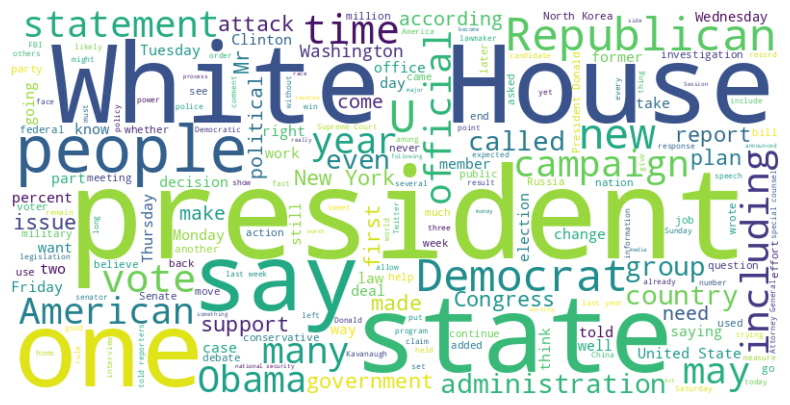

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(center_words)

# Create a Matplotlib figure
plt.figure(figsize=(10, 5))

# Display the word cloud with Seaborn styling
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Customize the color mapping using Seaborn
colormap = sns.color_palette("coolwarm", as_cmap=True)
wordcloud.recolor(colormap=colormap)

# Show the word cloud
plt.show()

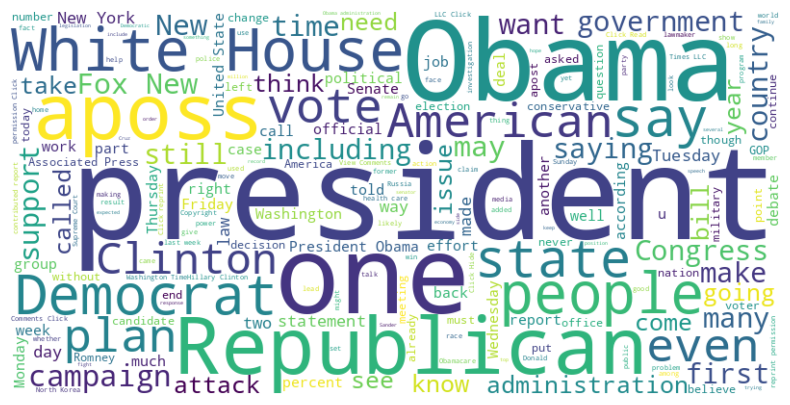

In [ ]:
# Create a WordCloud object
wordcloud_r = WordCloud(width=800, height=400, background_color='white').generate(right_words)

# Create a Matplotlib figure
plt.figure(figsize=(10, 5))

# Display the word cloud with Seaborn styling
plt.imshow(wordcloud_r, interpolation='bilinear')
plt.axis('off')

# Customize the color mapping using Seaborn
colormap = sns.color_palette("coolwarm", as_cmap=True)
wordcloud_r.recolor(colormap=colormap)

# Show the word cloud
plt.show()

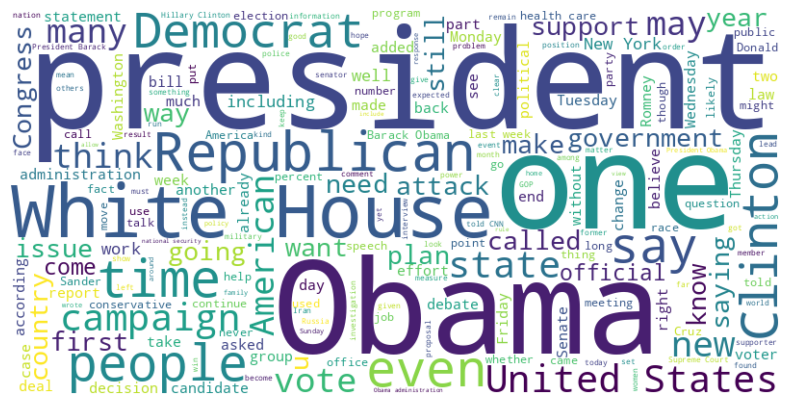

In [ ]:
# Create a WordCloud object
wordcloud_l = WordCloud(width=800, height=400, background_color='white').generate(left_words)

# Create a Matplotlib figure
plt.figure(figsize=(10, 5))

# Display the word cloud with Seaborn styling
plt.imshow(wordcloud_l, interpolation='bilinear')
plt.axis('off')

# Customize the color mapping using Seaborn
colormap = sns.color_palette("coolwarm", as_cmap=True)
wordcloud_l.recolor(colormap=colormap)

# Show the word cloud
plt.show()

### Article Length

In [ ]:
df['article_length'] = df['content'].apply(len)

<Axes: xlabel='article_length', ylabel='Count'>

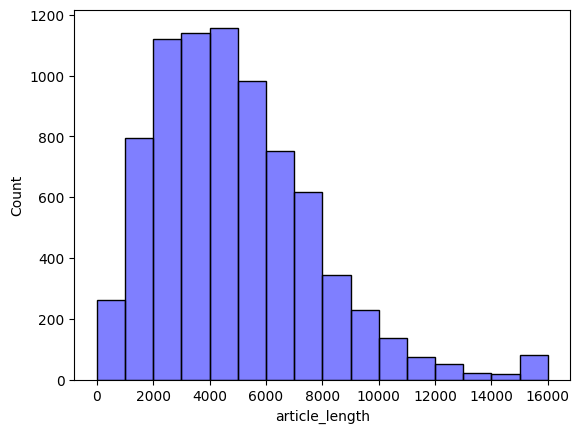

In [ ]:
sns.histplot(df['article_length'].clip(upper=df.article_length.quantile(0.99)), binwidth = 1000, color='b', alpha = 0.5, label="Article Character length")

### Author Bias

In [ ]:
df['author'] = df.misc.apply(lambda x : x.get('author', []))

In [ ]:
df_author = df[['author', 'allsides_bias']]

In [ ]:
df_author = df_author.explode('author')

In [ ]:
df_author = df_author[df_author.author.notnull()]

In [ ]:
df_author = df_author[~df_author.author.isin(['| Fox News'])]

In [ ]:
df_author_a = df_author.groupby('author')['allsides_bias'].value_counts().unstack(-1,0)

In [ ]:
df_author_a['total'] = df_author_a['From the Center'] + df_author_a['From the Left'] + df_author_a['From the Right']

In [ ]:
df_author_a.sort_values(by='From the Left', ascending=False).head().style.set_properties(subset=['From the Left'], **{'background-color': 'yellow'})

allsides_bias,From the Center,From the Left,From the Right,total
author,,,,
John A. Farrell,0,403,1,404
Cliff Sims,0,403,1,404
Jeff Greenfield,0,403,1,404
Frida Ghitis,1,304,1,306
Bill Scher,0,100,0,100


In [ ]:
df_author_a.sort_values(by='From the Right', ascending=False).head().style.set_properties(subset=['From the Right'], **{'background-color': 'yellow'})

allsides_bias,From the Center,From the Left,From the Right,total
author,,,,
Dave Boyer,0,0,73,73
Stephen Dinan,0,0,71,71
@KatiePavlich,0,0,62,62
Katie Pavlich,0,0,62,62
David Sherfinski,0,1,59,60


In [ ]:
df_author_a.sort_values(by='From the Center', ascending=False).head().style.set_properties(subset=['From the Center'], **{'background-color': 'yellow'})

allsides_bias,From the Center,From the Left,From the Right,total
author,,,,
David Jackson,50,0,0,50
John Bacon,23,0,0,23
Doug Stanglin,21,0,0,21
Jordan Fabian,21,0,0,21
Jeff Mason,19,2,0,21
